In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

In [6]:
fname = "/mnt/c/Users/Алексей/Documents/MEGAsync/cmm_paper/data/e1/e1.merged.15runs.csv"
df = pd.read_csv(fname)

#for each combination of "i_h2","i_p_c","i_p_nc","i_s2","i_repeat" take the run with the min cost function value
df = df.sort_values("cost").groupby(by=["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"],as_index=False).first()
column_cases = ["i_p_c","i_p_nc","i_s2","i_h2"]

cases_par = [{"A":'$10^{-1}$',"B":'$10^{-2}$',"C":'$10^{-3}$'},{"A":'$10^{-2}$',"B":'$10^{-3}$',"C":'$10^{-4}$'},
            {"A":'0.1',"B":'1.0',"C":' 10'},{"A":'0.1',"B":'0.4',"C":'0.7'}]

# add case column: i_p_c + i_p_nc + i_s2 + i_h2 -> "ABCA"
# HSQ=(0.1 0.4 0.7)
# CODING_CAUSALS=(16363 1636 163) # N_CODING = 163636
# NONCODING_CAUSALS=(108521 10852 1085) # N_NONCODING = 10852197
# SIGMA2_CODING=(0.1 1.0 10.0)
#     P_c   P_nc   s2_c/s2_nc    h2 
# A    -1     -2          0.1   0.1 
# B    -2     -3            1   0.4
# C    -3     -4           10   0.7
df["case"] = df[column_cases].sum(axis=1)
if True: # save best results for each simulation case (generates a table with 810 rows)
    out_fname = "/mnt/c/Users/Алексей/Documents/MEGAsync/cmm_paper/data/e1/e1.merged.15runs.best.csv"
    df.to_csv(out_fname,sep=',',index=False)

In [17]:
cols_true = ['p_nc','p_c','s2_nc','s2_c','h2_nc','h2_c']
cols_sim = ["sim_"+c for c in cols_true]
err_suffixes = ["_err_min", "_err_max"]
sim_err = [c+s for c in cols_sim for s in err_suffixes]
sim_vec = [c+"_vec" for c in cols_sim]

Case = namedtuple("Case",["name"] + cols_true + cols_sim + sim_err + sim_vec)
# cases2plot = ["BBBB", "BBBA", "CBCA", "ACAA", "CCCA", "ABAB", "BCAB"] # order of columns: "i_p_c","i_p_nc","i_s2","i_h2"
# cases2plot.sort()
# cases2plot = cases2plot[::-1]
cases2plot = [pc+pnc+s2+h2 for pc in "ABC" for pnc in "ABC" for s2 in "ABC" for h2 in "C"]
cases = []
for case in cases2plot:
    df_case = df.loc[df["case"]==case,:]
    case_dict = {"name":case}
    
    for c in cols_true:
        case_dict[c] = df_case[c].median()
    for c in cols_sim:
        median = df_case[c].median()
        case_dict[c] = median
        case_dict[c+"_vec"] = df_case[c].values
        case_dict[c+"_err_min"] = median - df_case[c].min()
        case_dict[c+"_err_max"] = df_case[c].max() - median
    cases.append(Case(**case_dict))
print(f"{len(cases2plot)} cases to plot")   

27 cases to plot


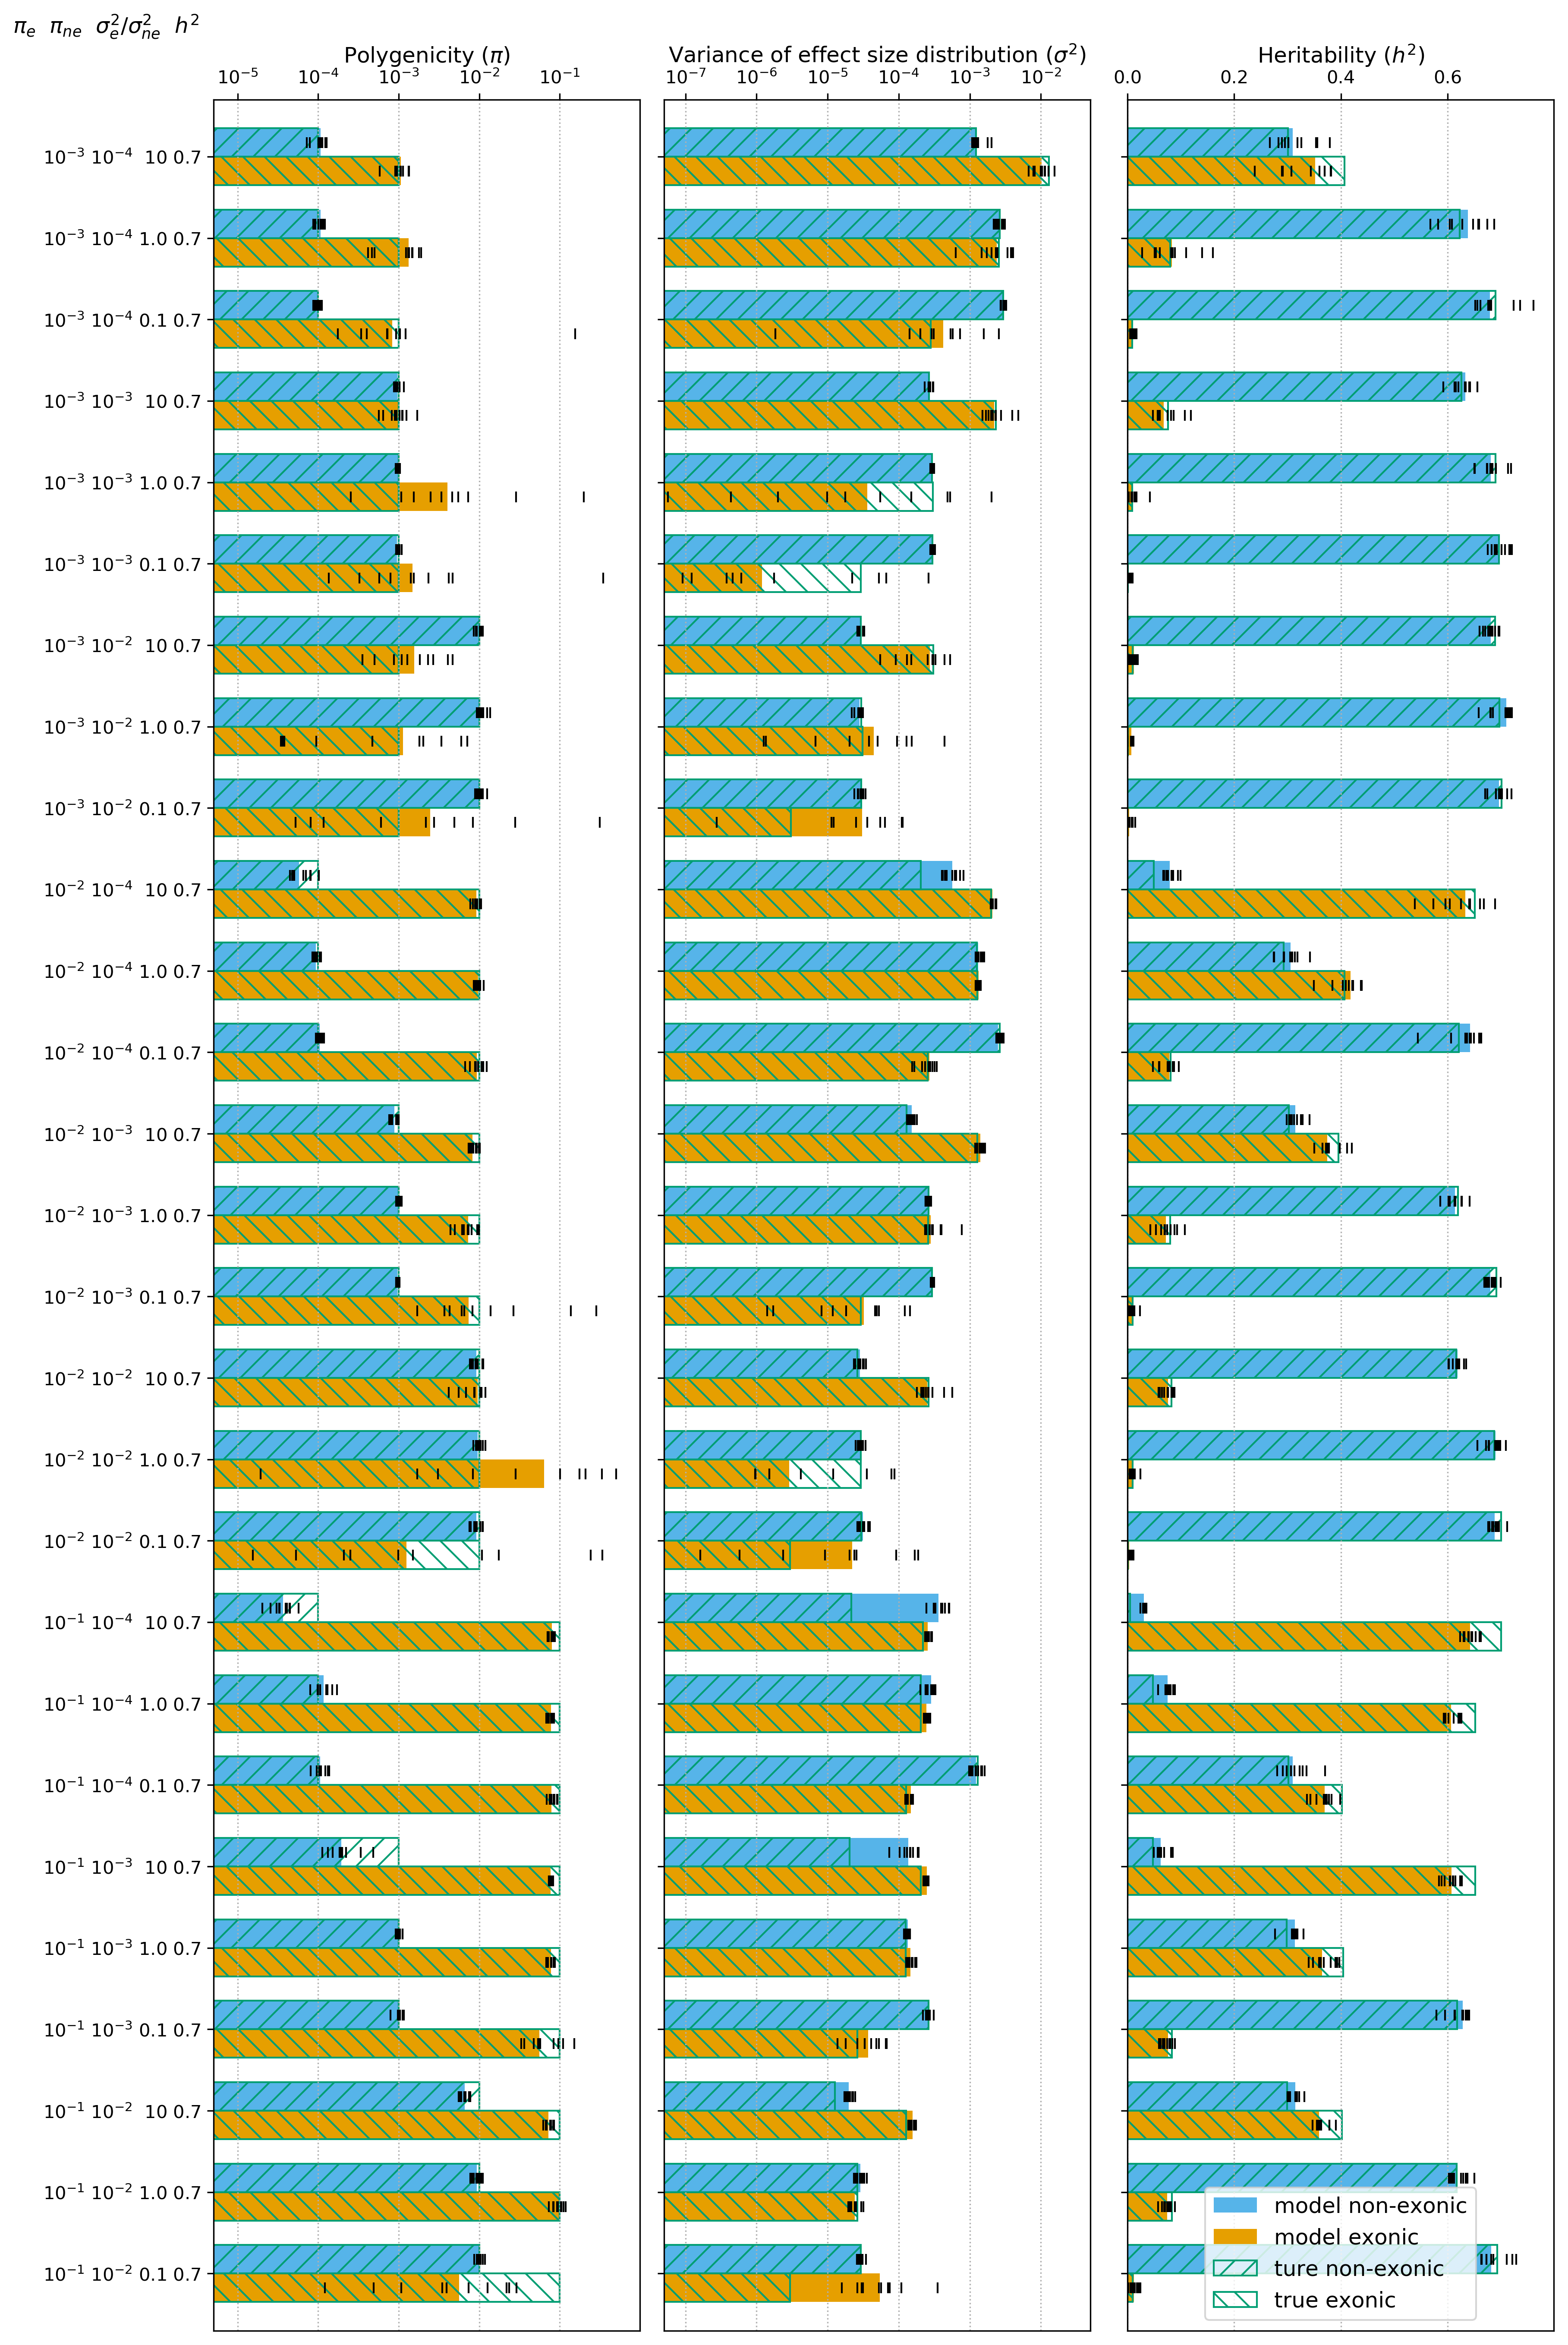

In [18]:
# outf = None
# outf = "e1_selected_cases.7cases.15runs.07.svg"
outf = "e1_XXXC_h2_07_cases.07.svg"
fig_width = len(cases2plot)*4/6
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,fig_width), sharey=True, constrained_layout=True, dpi=300,
                       gridspec_kw={'width_ratios':[1,1,1]})

# y_labels = [".".join(c) for c in cases2plot]
y_labels = [" ".join([cases_par[i][a] for i,a in enumerate(case)]) for case in cases2plot]
y_pos = np.arange(len(cases))
bottom_ticks = False
width = 0.7
sim_vec_spread = 0.0
err_line = False
err_line_width = 1.2
color_coding = "#e69f00"
color_noncoding = "#56b4e9"
color_err_coding = "k"
color_err_noncoding = "k"
color_true = "#009e73"

# plot p
p_nc_true = [c.p_nc for c in cases]
p_c_true = [c.p_c for c in cases]
p_nc_sim = [c.sim_p_nc for c in cases]
p_c_sim = [c.sim_p_c for c in cases]
p_nc_sim_err_min = [c.sim_p_nc_err_min for c in cases]
p_nc_sim_err_max = [c.sim_p_nc_err_max for c in cases]
p_nc_sim_err = [p_nc_sim_err_min, p_nc_sim_err_max]
p_c_sim_err_min = [c.sim_p_c_err_min for c in cases]
p_c_sim_err_max = [c.sim_p_c_err_max for c in cases]
p_c_sim_err = [p_c_sim_err_min, p_c_sim_err_max]
if not err_line:
    p_nc_sim_err = None
    p_c_sim_err = None

axs[0].barh(y_pos, p_nc_sim, 0.5*width, xerr=p_nc_sim_err, align="edge", color=color_noncoding,
            error_kw={"ecolor":color_err_noncoding, "elinewidth":err_line_width}, label="non-exonic")
axs[0].barh(y_pos, p_c_sim, -0.5*width, xerr=p_c_sim_err, align="edge", color=color_coding,
            error_kw={"ecolor":color_err_coding, "elinewidth":err_line_width}, label="exonic")
axs[0].barh(y_pos, p_nc_true, 0.5*width, align="edge", fill=False, hatch="//", edgecolor=color_true)
axs[0].barh(y_pos, p_c_true, -0.5*width, align="edge", fill=False, hatch=r'\\', edgecolor=color_true)    

axs[0].set_xlabel('Polygenicity ($\pi$)', fontsize=12)
axs[0].xaxis.set_label_position('top') 
axs[0].xaxis.tick_top()
axs[0].set_xscale('log')
axs[0].xaxis.grid(linestyle=':')
axs[0].set_yticklabels(y_labels, fontsize=10)

# plot s2
s2_nc_true = [c.s2_nc for c in cases]
s2_c_true = [c.s2_c for c in cases]
s2_nc_sim = [c.sim_s2_nc for c in cases]
s2_c_sim = [c.sim_s2_c for c in cases]
s2_nc_sim_err_min = [c.sim_s2_nc_err_min for c in cases]
s2_nc_sim_err_max = [c.sim_s2_nc_err_max for c in cases]
s2_nc_sim_err = [s2_nc_sim_err_min, s2_nc_sim_err_max]
s2_c_sim_err_min = [c.sim_s2_c_err_min for c in cases]
s2_c_sim_err_max = [c.sim_s2_c_err_max for c in cases]
s2_c_sim_err = [s2_c_sim_err_min, s2_c_sim_err_max]
if not err_line:
    s2_nc_sim_err = None
    s2_c_sim_err = None


axs[1].barh(y_pos, s2_nc_sim, 0.5*width, xerr=s2_nc_sim_err, align="edge", color=color_noncoding,
            error_kw={"ecolor":color_err_noncoding,"elinewidth":err_line_width}, label="non-exonic")
axs[1].barh(y_pos, s2_c_sim, -0.5*width, xerr=s2_c_sim_err, align="edge", color=color_coding,
            error_kw={"ecolor":color_err_coding, "elinewidth":err_line_width}, label="exonic")
axs[1].barh(y_pos, s2_nc_true, 0.5*width, align="edge", fill=False, hatch='//', edgecolor=color_true)
axs[1].barh(y_pos, s2_c_true, -0.5*width, align="edge", fill=False, hatch=r'\\', edgecolor=color_true)

axs[1].set_xlabel('Variance of effect size distribution ($\sigma^{2}$)', fontsize=12)
axs[1].xaxis.set_label_position('top') 
axs[1].xaxis.tick_top()
axs[1].set_xscale('log')
axs[1].xaxis.grid(linestyle=':')


# plot h2
h2_nc_true = [c.h2_nc for c in cases]
h2_c_true = [c.h2_c for c in cases]
h2_nc_sim = [c.sim_h2_nc for c in cases]
h2_c_sim = [c.sim_h2_c for c in cases]
h2_nc_sim_err_min = [c.sim_h2_nc_err_min for c in cases]
h2_nc_sim_err_max = [c.sim_h2_nc_err_max for c in cases]
h2_nc_sim_err = [h2_nc_sim_err_min, h2_nc_sim_err_max]
h2_c_sim_err_min = [c.sim_h2_c_err_min for c in cases]
h2_c_sim_err_max = [c.sim_h2_c_err_max for c in cases]
h2_c_sim_err = [h2_c_sim_err_min, h2_c_sim_err_max]
if not err_line:
    h2_nc_sim_err = None
    h2_c_sim_err = None

axs[2].barh(y_pos, h2_nc_sim, 0.5*width, align="edge", xerr=h2_nc_sim_err, color=color_noncoding,
            error_kw={"ecolor":color_err_coding, "elinewidth":err_line_width},label="model non-exonic")
axs[2].barh(y_pos, h2_c_sim, -0.5*width, align="edge", xerr=h2_c_sim_err, color=color_coding,
            error_kw={"ecolor":color_err_coding, "elinewidth":err_line_width},label="model exonic")
axs[2].barh(y_pos, h2_nc_true, 0.5*width, align="edge", fill=False, hatch='//', edgecolor=color_true,label="ture non-exonic")
axs[2].barh(y_pos, h2_c_true, -0.5*width, align="edge", fill=False, hatch=r'\\', edgecolor=color_true, label="true exonic")
axs[2].set_yticks(y_pos)

axs[2].set_xlabel("Heritability ($h^2$)", fontsize=12)
axs[2].xaxis.set_label_position('top') 
axs[2].xaxis.tick_top()
axs[2].xaxis.grid(linestyle=':')

axs[2].legend(loc='best',fontsize=12)

# add individual points
for y,c in zip(y_pos,cases):
    c_dict = c._asdict()
    for col in cols_true:
        ax_i = 0
        if col[0] == "s":
            ax_i = 1
        elif col[0] == "h":
            ax_i = 2
        width_factor = 0.25 if col.split("_")[1] == "nc" else -0.25
        
        k = "sim_" + col + "_vec"
        sim_vec = c_dict[k]
        y_sim_vec = y + width_factor*width + sim_vec_spread*(0.5 - np.random.rand(len(sim_vec)))
        axs[ax_i].plot(sim_vec,y_sim_vec,ls=' ',marker='|',ms=6,color='k')

for ax in axs:
    if bottom_ticks:
        ax.tick_params(axis='x', which='major', bottom=True,labelbottom=True)
    ax.minorticks_off()
    ax.set_ylim((-width,len(cases2plot)-1+width))
axs[0].set_xlim((5.E-6,0.99))
axs[1].set_xlim((5.E-8,5.E-2))

par_label = r'$\pi_e$  $\pi_{ne}$  $\sigma^2_e/\sigma^2_{ne}$  $h^2$'
axs[0].annotate(par_label, (-0.47, 1.03), xycoords = "axes fraction", fontsize=12)

if not outf is None:
    plt.savefig(outf)

df_case.columns

In [11]:
df.head()

,i_h2,i_p_c,i_p_nc,i_s2,i_repeat,run,p_nc,p_c,s2_nc,s2_c,...,glob_nfev,glob_cost,qual_p_nc,qual_p_c,qual_s2_nc,qual_s2_c,qual_h2,qual_h2_nc,qual_h2_c,qual_s02
0,A,A,A,A,1,1,0.01,0.099996,0.000004,4.147107e-07,...,632,1.469783,0.051682,-0.305485,-0.083509,-0.105619,-0.725943,-0.646791,-0.079153,0.627053
1,A,A,A,A,2,10,0.01,0.099996,0.000004,4.138632e-07,...,704,1.476198,-0.450359,-3.893535,0.415172,0.334301,-0.883031,-0.752086,-0.130945,2.231135
2,A,A,A,A,3,1,0.01,0.099996,0.000004,4.070084e-07,...,674,1.470135,0.135529,-0.535429,-0.198569,1.244887,-0.835635,-1.365995,0.530360,0.882929
3,A,A,A,A,4,1,0.01,0.099996,0.000004,4.195891e-07,...,602,1.469657,-0.400064,0.901503,0.363018,-0.218911,-0.361465,-0.870189,0.508724,0.109118
4,A,A,A,A,5,8,0.01,0.099996,0.000004,4.249198e-07,...,662,1.472657,0.068579,-2.400049,-0.083098,2.384932,-0.363266,-0.361403,-0.001863,0.790722


In [25]:
cases

[Case(name='BABB', p_nc=0.00999991061717733, p_c=0.0099977999951111, s2_nc=1.6786858344952716e-05, s2_c=1.655940161980984e-05, h2_nc=0.394588328578474, h2_c=0.005284628113383916, sim_p_nc=0.0117600181929024, sim_p_c=0.016923398890291354, sim_s2_nc=1.442669922345304e-05, sim_s2_c=4.800741480842215e-06, sim_h2_nc=0.3938247265751301, sim_h2_c=0.004742540686469227, sim_p_nc_err_min=0.008342970577956191, sim_p_nc_err_max=0.0133297539829184, sim_p_c_err_min=2.5438310242667076e-05, sim_p_c_err_max=0.0526461630261215, sim_s2_nc_err_min=1.2566085410752362e-05, sim_s2_nc_err_max=1.9478819486328736e-05, sim_s2_c_err_min=3.846857895484442e-08, sim_s2_c_err_max=0.00020557031175814352, sim_h2_nc_err_min=0.3796319576203887, sim_h2_nc_err_max=0.41585368229537983, sim_h2_c_err_min=1.1698258166286314e-07, sim_h2_c_err_max=0.009372080072989224),
 Case(name='CCBA', p_nc=9.99797552514021e-05, p_c=0.0009961133246962769, s2_nc=0.00038031087839981623, s2_c=0.0003471051493383865, h2_nc=0.08846248019951398, h2_

In [73]:
df.loc[df.case=="BABB",column_cases+["i_repeat"]+cols_true+cols_sim]

,i_p_c,i_p_nc,i_s2,i_h2,p_nc,p_c,s2_nc,s2_c,h2_nc,h2_c,sim_p_nc,sim_p_c,sim_s2_nc,sim_s2_c,sim_h2_nc,sim_h2_c
370,B,A,B,B,0.01,0.009998,0.000017,0.000017,0.395462,0.005280,0.012359,0.052646,0.000014,8.546507e-07,0.415854,1.431301e-03
371,B,A,B,B,0.01,0.009998,0.000017,0.000018,0.394366,0.005883,0.012341,0.000983,0.000014,1.505418e-04,0.396216,4.708796e-03
372,B,A,B,B,0.01,0.009998,0.000016,0.000016,0.389865,0.004976,0.011739,0.001433,0.000015,2.055703e-04,0.402599,9.372080e-03
373,B,A,B,B,0.01,0.009998,0.000017,0.000016,0.395190,0.005178,0.012379,0.000096,0.000013,3.846858e-08,0.386203,1.169826e-07
374,B,A,B,B,0.01,0.009998,0.000017,0.000017,0.398492,0.005419,0.010047,0.000025,0.000017,6.606054e-07,0.398424,5.345717e-07
375,B,A,B,B,0.01,0.009998,0.000017,0.000016,0.394743,0.005332,0.010065,0.044337,0.000016,5.055395e-06,0.379632,7.130173e-03
376,B,A,B,B,0.01,0.009998,0.000017,0.000016,0.391381,0.005187,0.013330,0.003774,0.000013,3.977937e-05,0.394431,4.776285e-03
377,B,A,B,B,0.01,0.009998,0.000017,0.000017,0.391147,0.005445,0.011781,0.030072,0.000014,4.546088e-06,0.393219,4.348910e-03
378,B,A,B,B,0.01,0.009998,0.000017,0.000017,0.398254,0.005289,0.008343,0.032083,0.000019,6.276807e-06,0.382677,6.406004e-03
379,B,A,B,B,0.01,0.009998,0.000017,0.000016,0.394433,0.005273,0.010962,0.047329,0.000015,3.975219e-06,0.387276,5.985044e-03


In [91]:
df_case = df.loc[df["case"]=="CBCA",:]
df_case

,i_h2,i_p_c,i_p_nc,i_s2,i_repeat,run,p_nc,p_c,s2_nc,s2_c,...,glob_cost,qual_p_nc,qual_p_c,qual_s2_nc,qual_s2_c,qual_h2,qual_h2_nc,qual_h2_c,qual_s02,case
230,A,C,B,C,1,1,0.001,0.000996,0.000035,0.000429,...,1.473234,-0.028377,-0.032467,0.133071,0.044833,1.991192,2.119226,-0.128034,-0.541824,CBCA
231,A,C,B,C,2,1,0.001,0.000996,0.000037,0.000386,...,1.467045,-0.067608,-0.107720,0.039598,0.036347,-1.017035,-0.667684,-0.349351,0.522467,CBCA
232,A,C,B,C,3,4,0.001,0.000996,0.000038,0.000337,...,1.471039,-0.161289,1.984472,0.184343,-3.243863,-0.422791,0.707125,-1.129916,0.983541,CBCA
233,A,C,B,C,4,1,0.001,0.000996,0.000039,0.000317,...,1.468536,0.082301,-0.003577,-0.117160,0.042529,-0.585963,-0.604091,0.018128,0.573707,CBCA
234,A,C,B,C,5,1,0.001,0.000996,0.000037,0.000412,...,1.466457,-0.200101,0.031790,0.059185,-0.022244,-2.290024,-2.240790,-0.049234,1.978009,CBCA
235,A,C,B,C,6,1,0.001,0.000996,0.000037,0.000311,...,1.471299,-0.065492,0.244729,0.058063,0.281813,2.087886,-0.208043,2.295928,-0.199359,CBCA
236,A,C,B,C,7,8,0.001,0.000996,0.000038,0.000423,...,1.467751,-0.053591,-0.962246,0.092604,-2.643056,-0.105224,0.973243,-1.078467,-0.155299,CBCA
237,A,C,B,C,8,1,0.001,0.000996,0.000035,0.000419,...,1.471224,-0.045458,0.172069,0.024560,0.052078,0.142155,-0.469164,0.611319,0.859222,CBCA
238,A,C,B,C,9,1,0.001,0.000996,0.000038,0.000355,...,1.466048,-0.059328,-0.063373,0.050404,-0.076316,-0.290186,-0.112220,-0.177966,-0.045170,CBCA
239,A,C,B,C,10,1,0.001,0.000996,0.000037,0.000364,...,1.470833,-0.055229,-0.047620,0.022001,0.139807,-0.554227,-0.604581,0.050354,1.174591,CBCA


In [129]:
c["p_nc"]

TypeError: tuple indices must be integers or slices, not str